# IBM-Coursera_Capstone - Restaurant Battle of Neighborhoods in Paris

## Part 00 - Import the needed Library

In [1]:
## import the needed Library
import pandas as pd
import numpy as np
import urllib
from bs4 import BeautifulSoup
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geopy
from  geopy.geocoders import Nominatim
nominatim_service = Nominatim(user_agent='X@yy.com') # Important line
geopy.geocoders.options.default_user_agent = "X@yy.com" # Important line
geolocator = Nominatim()

print('package installed')

Solving environment: done

## Package Plan ##

  environment location: /Users/Phil/opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.10.1-py38hecd8cb5_1 --> conda-forge::conda-4.10.1-py38h50d1736_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

package installed


## Part 01 - Data Acquisition

Data,in geojson format, are available on the web site https://opendata.paris.fr/explore/dataset/arrondissements/export/?location=13,48.85156,2.32327.

I saved these files in the same directory as my jupyter notebook.

In [2]:
geo_borough = json.load(open("arrondissements.geojson")) # Paris arrondissements
geo_neighbourhood = json.load(open("quartier_paris.geojson")) # Paris neighborhoods

The GeoJSON format is used to represent data of a geographic type. It follows precise specifications, and can be used directly as we will see later.

In this object, transformed into a dictionary under python, there are two elements: the type and the information (named features)

In [3]:
geo_borough.keys()

dict_keys(['type', 'features'])

In [4]:
geo_borough["type"]

'FeatureCollection'

We are checking that we have the 20 arrondissements of Paris in the features object, which is a list.

In [5]:
len(geo_borough["features"])

20

In each object of this list, we also have different Feature type objects.

In [6]:
geo_borough["features"][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [7]:
geo_borough["features"][0]['type']

'Feature'

In the properties field, there are various useful information, including the longitude and latitude coordinates of the center.

In [8]:
geo_borough["features"][0]['properties']

{'n_sq_co': 750001537,
 'perimetre': 4519.26364836,
 'l_ar': '3ème Ardt',
 'surface': 1170882.82818778,
 'geom_x_y': [48.86287238, 2.3600009859],
 'n_sq_ar': 750000003,
 'l_aroff': 'Temple',
 'c_arinsee': 75103,
 'c_ar': 3}

In [9]:
geo_neighbourhood["features"][0]['properties']

{'n_sq_qu': 750000015,
 'n_sq_ar': 750000004,
 'geom_x_y': [48.851585175, 2.36476795387],
 'c_qu': 15,
 'surface': 487264.93707154,
 'l_qu': 'Arsenal',
 'perimetre': 2878.55965556,
 'c_quinsee': 7510403,
 'c_ar': 4}

For the rest of the project, with the Panda library imported previously, we create 2 DataFrames with the useful information.

In [10]:
# Borough Dataframe
bouroughDF = pd.DataFrame({
     "BoroughNumber"    : [bor["properties"]["c_ar"] for bor in geo_borough["features"]]
    ,"Borough"          : [bor["properties"]["l_aroff"] for bor in geo_borough["features"]]
    ,"Latitude"   : [bor["properties"]["geom_x_y"][0] for bor in geo_borough["features"]]
    ,"Longitude" : [bor["properties"]["geom_x_y"][1] for bor in geo_borough["features"]]
    ,"BoroughPerimetre" : [bor["properties"]["perimetre"] for bor in geo_borough["features"]]
})
bouroughDF

,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre
0,3,Temple,48.862872,2.360001,4519.263648
1,7,Palais-Bourbon,48.856174,2.312188,8099.424883
2,13,Gobelins,48.828388,2.362272,11546.546526
3,17,Batignolles-Monceau,48.887327,2.306777,10775.579516
4,20,Ménilmontant,48.863461,2.401188,10704.940486
5,10,Entrepôt,48.876130,2.360728,6739.375055
6,12,Reuilly,48.834974,2.421325,24089.666298
7,5,Panthéon,48.844443,2.350715,6239.195396
8,8,Élysée,48.872721,2.312554,7880.533268
9,15,Vaugirard,48.840085,2.292826,13678.798315


In [11]:
# Neighbourhood Dataframe
neighbourhoodDF = pd.DataFrame({
    "BoroughNumber"  : [neigh["properties"]["c_ar"] for neigh in geo_neighbourhood["features"]]
    ,"NeighNumber"   : [neigh["properties"]['c_qu'] for neigh in geo_neighbourhood["features"]]
    ,"Neighbourhood" : [neigh["properties"]["l_qu"] for neigh in geo_neighbourhood["features"]]
    #,"NeighLatitude" : [neigh["properties"]["geom_x_y"][0] for neigh in geo_neighbourhood["features"]]
    #,"NeighLongitude": [neigh["properties"]["geom_x_y"][1] for neigh in geo_neighbourhood["features"]]
    #,"NeighPerimetre": [neigh["properties"]["perimetre"] for neigh in geo_neighbourhood["features"]]
})
neighbourhoodDF

,BoroughNumber,NeighNumber,Neighbourhood
0,4,15,Arsenal
1,5,18,Jardin-des-Plantes
2,10,39,Porte-Saint-Martin
3,11,43,Roquette
4,12,46,Picpus
...,...,...,...
75,19,75,Amérique
76,8,32,Europe
77,11,44,Sainte-Marguerite
78,14,54,Parc-de-Montsouris


### Merge boroughDF with neighbourhoodDF => borough_neighbourhoodDF

In [12]:
borough_neighbourhoodDF= bouroughDF.set_index('BoroughNumber').join(neighbourhoodDF.set_index('BoroughNumber')).reset_index()
#borough_neighbourhoodDF.columns = ['BoroughCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']
borough_neighbourhoodDF.head()
#postalCodesDF_geo = postalCodesDF_combined.set_index('Postal Code').join(postalCodesLatLngDF.set_index('Postal Code')).reset_index()
#postalCodesDF_geo
#postalCodesDF_geo.columns = ['PostalCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']
#postalCodesDF_geo

,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,Neighbourhood
0,1,Louvre,48.862563,2.336443,6054.936862,3,Palais-Royal
1,1,Louvre,48.862563,2.336443,6054.936862,1,Saint-Germain-l'Auxerrois
2,1,Louvre,48.862563,2.336443,6054.936862,2,Halles
3,1,Louvre,48.862563,2.336443,6054.936862,4,Place-Vendôme
4,2,Bourse,48.868279,2.342803,4554.104360,6,Vivienne


### More than one neighborhood can exist in one postal code area.Rows will be combined into one row with the neighborhoods separated with a comma

In [13]:
#concat neighborhood
postalCodesDF_combined = borough_neighbourhoodDF.groupby(['BoroughNumber', 'Borough','Latitude','Longitude'])['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
#convert into dataframe
postalCodesDF_combined = postalCodesDF_combined.to_frame().reset_index()
postalCodesDF_combined

,BoroughNumber,Borough,Latitude,Longitude,Neighbourhood
0,1,Louvre,48.862563,2.336443,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle..."
1,2,Bourse,48.868279,2.342803,"Vivienne, Mail, Bonne-Nouvelle, Gaillon"
2,3,Temple,48.862872,2.360001,"Sainte-Avoie, Arts-et-Métiers, Archives, Enfan..."
3,4,Hôtel-de-Ville,48.854341,2.357630,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame"
4,5,Panthéon,48.844443,2.350715,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va..."
5,6,Luxembourg,48.849130,2.332898,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,..."
6,7,Palais-Bourbon,48.856174,2.312188,"Saint-Thomas-d'Aquin, Ecole-Militaire, Gros-Ca..."
7,8,Élysée,48.872721,2.312554,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ..."
8,9,Opéra,48.877164,2.337458,"Saint-Georges, Chaussée-d'Antin, Rochechouart,..."
9,10,Entrepôt,48.876130,2.360728,"Porte-Saint-Martin, Porte-Saint-Denis, Hôpital..."


## Part 02 - Geo Data Acquisition

In [14]:
#FourSquare credential and version
CLIENT_ID = 'GU0EJCBEB0ACFSSHLIN1LY2QMDXMYC0GRPPYT1VSEMVDFTXM' # your Foursquare ID
CLIENT_SECRET = 'HKGI0ZJHHULNL2IKG0PXH42ILENLMQY3DJUCEDD1DQC1WSAH' # your Foursquare Secret
ACCESS_TOKEN = 'AQBQX232OWVPICDQ1YUWR4J2LZCTZM012NLPYZTTUROY3VP0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
#Your credentails:
#CLIENT_ID: GU0EJCBEB0ACFSSHLIN1LY2QMDXMYC0GRPPYT1VSEMVDFTXM
#CLIENT_SECRET:HKGI0ZJHHULNL2IKG0PXH42ILENLMQY3DJUCEDD1DQC1WSAH

Your credentails:
CLIENT_ID: GU0EJCBEB0ACFSSHLIN1LY2QMDXMYC0GRPPYT1VSEMVDFTXM
CLIENT_SECRET:HKGI0ZJHHULNL2IKG0PXH42ILENLMQY3DJUCEDD1DQC1WSAH


In [15]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#Get Paris Venues
paris_venues = getNearbyVenues(names=postalCodesDF_combined['Neighbourhood'],
                               latitudes=postalCodesDF_combined['Latitude'],
                               longitudes=postalCodesDF_combined['Longitude']
                                  )

Palais-Royal, Saint-Germain-l'Auxerrois, Halles, Place-Vendôme
Vivienne, Mail, Bonne-Nouvelle, Gaillon
Sainte-Avoie, Arts-et-Métiers, Archives, Enfants-Rouges
Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame
Jardin-des-Plantes, Sorbonne, Saint-Victor, Val-de-Grâce
Notre-Dame-des-Champs, Saint-Germain-des-Prés, Monnaie, Odéon
Saint-Thomas-d'Aquin, Ecole-Militaire, Gros-Caillou, Invalides
Madeleine, Faubourg-du-Roule, Champs-Elysées, Europe
Saint-Georges, Chaussée-d'Antin, Rochechouart, Faubourg-Montmartre
Porte-Saint-Martin, Porte-Saint-Denis, Hôpital-Saint-Louis, Saint-Vincent-de-Paul
Roquette, Saint-Ambroise, Folie-Méricourt, Sainte-Marguerite
Picpus, Quinze-Vingts, Bel-Air, Bercy
Gare, Salpêtrière, Maison-Blanche, Croulebarbe
Plaisance, Petit-Montrouge, Montparnasse, Parc-de-Montsouris
Necker, Grenelle, Javel, Saint-Lambert
Porte-Dauphine, Auteuil, Muette, Chaillot
Batignolles, Epinettes, Ternes, Plaine de Monceaux
Grandes-Carrières, La Chapelle, Clignancourt, Goutte-d'Or
Villette, Po

In [17]:
print(f'The Paris_venues data frame has {paris_venues.shape[0]} rows and {paris_venues.shape[1]} columns.')

The Paris_venues data frame has 1260 rows and 7 columns.


In [18]:
paris_venues

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Musée du Louvre,48.860847,2.336440,Art Museum
1,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Palais Royal,48.863236,2.337127,Historic Site
2,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Place du Palais Royal,48.862523,2.336688,Plaza
3,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Comédie-Française,48.863088,2.336612,Theater
4,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Cour Napoléon,48.861172,2.335088,Plaza
...,...,...,...,...,...,...,...
1255,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Restaurant Çamoluk,48.864941,2.405089,Kebab Restaurant
1256,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,L'Ogresse,48.861098,2.404889,Comedy Club
1257,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Il Pinocchio,48.867500,2.400757,Italian Restaurant
1258,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Au Pain Doré,48.859116,2.402075,Bakery


We filter out the venues that deal with food'n'drinks.

In [58]:
paris_Food = paris_venues[paris_venues['Venue Category'].str.contains('Restaurant|Bar|Snack|Food|Pizza')].reset_index(drop=True)
paris_Food.index = np.arange(1, len(paris_Food)+1)
paris_Food

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Cibus,48.864757,2.335377,Italian Restaurant
2,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,LouLou,48.862804,2.333500,Italian Restaurant
3,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Sanukiya,48.864713,2.333805,Udon Restaurant
4,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Le Pot de Vins,48.864322,2.340193,Restaurant
5,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Ellsworth,48.865528,2.337057,French Restaurant
...,...,...,...,...,...,...,...
590,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Le Ramus,48.863675,2.397556,Bar
591,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Franprix Rue des prairies,48.862800,2.403034,Food & Drink Shop
592,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Restaurant Çamoluk,48.864941,2.405089,Kebab Restaurant
593,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",48.863461,2.401188,Il Pinocchio,48.867500,2.400757,Italian Restaurant


We notice that in the Neighbourhood 'Picpus, Quinze-Vingts, Bel-Air, Bercy' there is no Restaurant, no Bar, no Snack, no Food, and no Pizza

In [20]:
paris_venues[ (paris_venues['Neighbourhood'] == 'Picpus, Quinze-Vingts, Bel-Air, Bercy')]

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
899,"Picpus, Quinze-Vingts, Bel-Air, Bercy",48.834974,2.421325,Rocher du Zoo de Vincennes,48.833523,2.418366,Monument / Landmark
900,"Picpus, Quinze-Vingts, Bel-Air, Bercy",48.834974,2.421325,Grande Serre du Parc Zoologique de Paris,48.833457,2.416617,Zoo Exhibit
901,"Picpus, Quinze-Vingts, Bel-Air, Bercy",48.834974,2.421325,Parc zoologique de Paris,48.832210,2.418365,Zoo
902,"Picpus, Quinze-Vingts, Bel-Air, Bercy",48.834974,2.421325,Franprix,48.838500,2.417570,Supermarket


In [21]:
print (paris_Food['Venue Category'].value_counts())

French Restaurant         165
Italian Restaurant         52
Japanese Restaurant        35
Cocktail Bar               27
Bar                        25
                         ... 
Shanxi Restaurant           1
Brazilian Restaurant        1
Argentinian Restaurant      1
Spanish Restaurant          1
Gluten-free Restaurant      1
Name: Venue Category, Length: 73, dtype: int64


In [22]:
print(f'There are {len(paris_Food["Venue Category"].unique())} unique types of food\'n\'drinks venues.')

There are 73 unique types of food'n'drinks venues.


In [23]:
# create a dataframe of top 10 categories
paris_venues_only_restaurant_Top10 = paris_Food['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
paris_venues_only_restaurant_Top10 = paris_venues_only_restaurant_Top10.reset_index()
paris_venues_only_restaurant_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
paris_venues_only_restaurant_Top10

,Venue_Category,Frequency
0,French Restaurant,165
1,Italian Restaurant,52
2,Japanese Restaurant,35
3,Cocktail Bar,27
4,Bar,25
5,Restaurant,24
6,Wine Bar,24
7,Vietnamese Restaurant,22
8,Asian Restaurant,18
9,Thai Restaurant,16


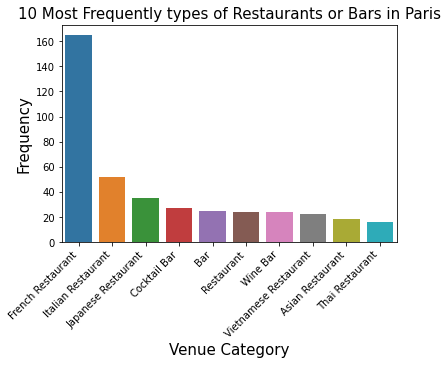

<Figure size 1296x504 with 0 Axes>

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=paris_venues_only_restaurant_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently types of Restaurants or Bars in Paris', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [25]:
paris_Food[['Neighbourhood','Venue']].groupby('Neighbourhood').count()

,Venue
Neighbourhood,
"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",37
"Batignolles, Epinettes, Ternes, Plaine de Monceaux",32
"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",45
"Grandes-Carrières, La Chapelle, Clignancourt, Goutte-d'Or",26
"Jardin-des-Plantes, Sorbonne, Saint-Victor, Val-de-Grâce",40
"Madeleine, Faubourg-du-Roule, Champs-Elysées, Europe",18
"Necker, Grenelle, Javel, Saint-Lambert",32
"Notre-Dame-des-Champs, Saint-Germain-des-Prés, Monnaie, Odéon",12
"Palais-Royal, Saint-Germain-l'Auxerrois, Halles, Place-Vendôme",28


In [26]:
paris_Food.groupby('Venue Category').max()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,"Roquette, Saint-Ambroise, Folie-Méricourt, Sai...",48.859059,2.380058,Afghanistan,48.862327,2.379999
African Restaurant,"Saint-Georges, Chaussée-d'Antin, Rochechouart,...",48.877164,2.360728,Wally Le Saharien,48.879211,2.361241
American Restaurant,"Villette, Pont-de-Flandre, Combat, Amérique",48.887076,2.384821,Belushi's,48.888541,2.379129
Argentinian Restaurant,"Sainte-Avoie, Arts-et-Métiers, Archives, Enfan...",48.862872,2.360001,Anahi,48.867002,2.358244
Asian Restaurant,"Vivienne, Mail, Bonne-Nouvelle, Gaillon",48.887327,2.380058,Yummy Asian Food,48.888780,2.382723
...,...,...,...,...,...,...
Udon Restaurant,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",48.862563,2.336443,Udon Bistro Kunitoraya (Kunitoraya),48.865884,2.336782
Vegetarian / Vegan Restaurant,"Sainte-Avoie, Arts-et-Métiers, Archives, Enfan...",48.877164,2.380058,Sol Semilla,48.878265,2.374566
Venezuelan Restaurant,"Saint-Georges, Chaussée-d'Antin, Rochechouart,...",48.877164,2.337458,Aji Dulce,48.877906,2.337878


## Part 03 - Clustering

In [27]:
paris_venues_encoded = pd.get_dummies(paris_Food[['Venue Category']], prefix="", prefix_sep="")
paris_venues_encoded

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,Basque Restaurant,Beer Bar,Brazilian Restaurant,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
paris_venues_encoded = pd.concat([paris_Food['Neighbourhood'],paris_venues_encoded],axis=1)
paris_venues_encoded.head(10)

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,Basque Restaurant,Beer Bar,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
1,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(f'This dataframe has {paris_venues_encoded.shape[0]} rows and {paris_venues_encoded.shape[1]} columns.')

This dataframe has 594 rows and 74 columns.


In [30]:
paris_grouped = paris_venues_encoded.groupby('Neighbourhood').mean().reset_index()
paris_grouped

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,Basque Restaurant,Beer Bar,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
0,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",0.000000,0.027027,0.00,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,...,0.000,0.000000,0.027027,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.081081
1,"Batignolles, Epinettes, Ternes, Plaine de Monc...",0.000000,0.000000,0.00,0.000000,0.031250,0.000000,0.031250,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",0.000000,0.000000,0.00,0.000000,0.244444,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.288889,0.000000
3,"Grandes-Carrières, La Chapelle, Clignancourt, ...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.230769,0.000000,0.038462,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462
4,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.075000,0.000000,0.000000,...,0.025,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.050000,0.050000
5,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Necker, Grenelle, Javel, Saint-Lambert",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,...,0.000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333
8,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714
9,"Plaisance, Petit-Montrouge, Montparnasse, Parc...",0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
print(f'This dataframe has {paris_grouped.shape[0]} rows and {paris_grouped.shape[1]} columns.')

This dataframe has 19 rows and 74 columns.


In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
#import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = paris_grouped['Neighbourhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",French Restaurant,Wine Bar,Cocktail Bar,Italian Restaurant,Gay Bar,Israeli Restaurant,Pizza Place,Portuguese Restaurant,Falafel Restaurant,Restaurant
1,"Batignolles, Epinettes, Ternes, Plaine de Monc...",French Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Asian Restaurant,Salon / Barbershop,Bar,Portuguese Restaurant
2,"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Jewish Restaurant
3,"Grandes-Carrières, La Chapelle, Clignancourt, ...",Bar,French Restaurant,Restaurant,Wine Bar,Beer Bar,Seafood Restaurant,Pizza Place,Health Food Store,Indian Restaurant,Fast Food Restaurant
4,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va...",French Restaurant,Italian Restaurant,Bar,Wine Bar,Vietnamese Restaurant,Falafel Restaurant,Greek Restaurant,Lebanese Restaurant,Pizza Place,Sushi Restaurant
5,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ...",French Restaurant,Corsican Restaurant,Cocktail Bar,Mediterranean Restaurant,Japanese Restaurant,Thai Restaurant,Modern European Restaurant,Bar,Italian Restaurant,Hotel Bar
6,"Necker, Grenelle, Javel, Saint-Lambert",Italian Restaurant,French Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Lebanese Restaurant,Restaurant,Cambodian Restaurant,Moroccan Restaurant,Russian Restaurant
7,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,...",French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Restaurant,Japanese Restaurant,Mexican Restaurant,Lebanese Restaurant,Taiwanese Restaurant,Jewish Restaurant
8,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Soba Restaurant,Wine Bar
9,"Plaisance, Petit-Montrouge, Montparnasse, Parc...",French Restaurant,Fast Food Restaurant,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Pizza Place,Gay Bar,Gluten-free Restaurant,Greek Restaurant,Health Food Store


### Running K-Means with k = 5

In [34]:
paris_k_clustering = paris_grouped.drop('Neighbourhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(paris_k_clustering)
    distortions.append(kmeanModel.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

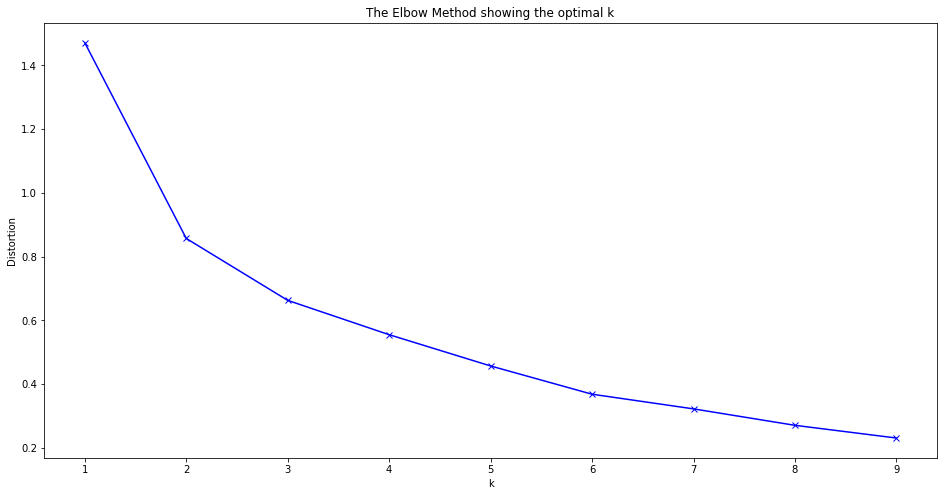

In [35]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

Looking at the figure above, we can conclude that 4 clusters would be our optimal choice for this case.

In [36]:
from sklearn.cluster import KMeans

k_clusters = 4

#drop the Neighbourhood column to work with numerical values only
paris_k_clustering = paris_grouped.drop('Neighbourhood', 1)

KM = KMeans(n_clusters=k_clusters, random_state=0)

In [37]:
KM.fit(paris_k_clustering)
KM

KMeans(n_clusters=4, random_state=0)

In [38]:
KM.labels_[0:10]

array([0, 0, 2, 3, 0, 0, 3, 3, 3, 1], dtype=int32)

boroughDF
BoroughNumber	Borough	BorouhLatitude	BoroughLongitude	

In [43]:
#adding the labels to the top10 df
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', KM.labels_)
neighbourhoods_venues_sorted
#creating a copy of df
#paris_final = df.copy()
#paris_final = neighbourhoods_venues_sorted
#paris_final

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",French Restaurant,Wine Bar,Cocktail Bar,Italian Restaurant,Gay Bar,Israeli Restaurant,Pizza Place,Portuguese Restaurant,Falafel Restaurant,Restaurant
1,0,"Batignolles, Epinettes, Ternes, Plaine de Monc...",French Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Asian Restaurant,Salon / Barbershop,Bar,Portuguese Restaurant
2,2,"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Jewish Restaurant
3,3,"Grandes-Carrières, La Chapelle, Clignancourt, ...",Bar,French Restaurant,Restaurant,Wine Bar,Beer Bar,Seafood Restaurant,Pizza Place,Health Food Store,Indian Restaurant,Fast Food Restaurant
4,0,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va...",French Restaurant,Italian Restaurant,Bar,Wine Bar,Vietnamese Restaurant,Falafel Restaurant,Greek Restaurant,Lebanese Restaurant,Pizza Place,Sushi Restaurant
5,0,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ...",French Restaurant,Corsican Restaurant,Cocktail Bar,Mediterranean Restaurant,Japanese Restaurant,Thai Restaurant,Modern European Restaurant,Bar,Italian Restaurant,Hotel Bar
6,3,"Necker, Grenelle, Javel, Saint-Lambert",Italian Restaurant,French Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Lebanese Restaurant,Restaurant,Cambodian Restaurant,Moroccan Restaurant,Russian Restaurant
7,3,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,...",French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Restaurant,Japanese Restaurant,Mexican Restaurant,Lebanese Restaurant,Taiwanese Restaurant,Jewish Restaurant
8,3,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Soba Restaurant,Wine Bar
9,1,"Plaisance, Petit-Montrouge, Montparnasse, Parc...",French Restaurant,Fast Food Restaurant,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Pizza Place,Gay Bar,Gluten-free Restaurant,Greek Restaurant,Health Food Store


In [44]:
paris_venues_final = neighbourhoods_venues_sorted.join(postalCodesDF_combined.set_index('Neighbourhood'), on='Neighbourhood')
paris_venues_final
#test = neighbourhoods_venues_sorted.join(postalCodesDF_combined.set_index('BoroughNumber'), on='BoroughNumber')
#test

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude
0,0,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",French Restaurant,Wine Bar,Cocktail Bar,Italian Restaurant,Gay Bar,Israeli Restaurant,Pizza Place,Portuguese Restaurant,Falafel Restaurant,Restaurant,4,Hôtel-de-Ville,48.854341,2.357630
1,0,"Batignolles, Epinettes, Ternes, Plaine de Monc...",French Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Asian Restaurant,Salon / Barbershop,Bar,Portuguese Restaurant,17,Batignolles-Monceau,48.887327,2.306777
2,2,"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Jewish Restaurant,13,Gobelins,48.828388,2.362272
3,3,"Grandes-Carrières, La Chapelle, Clignancourt, ...",Bar,French Restaurant,Restaurant,Wine Bar,Beer Bar,Seafood Restaurant,Pizza Place,Health Food Store,Indian Restaurant,Fast Food Restaurant,18,Buttes-Montmartre,48.892569,2.348161
4,0,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va...",French Restaurant,Italian Restaurant,Bar,Wine Bar,Vietnamese Restaurant,Falafel Restaurant,Greek Restaurant,Lebanese Restaurant,Pizza Place,Sushi Restaurant,5,Panthéon,48.844443,2.350715
5,0,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ...",French Restaurant,Corsican Restaurant,Cocktail Bar,Mediterranean Restaurant,Japanese Restaurant,Thai Restaurant,Modern European Restaurant,Bar,Italian Restaurant,Hotel Bar,8,Élysée,48.872721,2.312554
6,3,"Necker, Grenelle, Javel, Saint-Lambert",Italian Restaurant,French Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Lebanese Restaurant,Restaurant,Cambodian Restaurant,Moroccan Restaurant,Russian Restaurant,15,Vaugirard,48.840085,2.292826
7,3,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,...",French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Restaurant,Japanese Restaurant,Mexican Restaurant,Lebanese Restaurant,Taiwanese Restaurant,Jewish Restaurant,6,Luxembourg,48.849130,2.332898
8,3,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Soba Restaurant,Wine Bar,1,Louvre,48.862563,2.336443
9,1,"Plaisance, Petit-Montrouge, Montparnasse, Parc...",French Restaurant,Fast Food Restaurant,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Pizza Place,Gay Bar,Gluten-free Restaurant,Greek Restaurant,Health Food Store,14,Observatoire,48.829245,2.326542


In [45]:
#check for null values
paris_venues_final[paris_venues_final['Cluster Labels'].isnull()]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude


## Part 04 - Clusters Analysis

Examine Clusters - 
We can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### Cluster 1

Cluster 1 contains a higher concentration of French Restaurants and Bars

In [46]:
cluster = 0
paris_venues_final.loc[paris_venues_final['Cluster Labels'] == cluster, paris_venues_final.columns[[1] + list(range(2, paris_venues_final.shape[1]))]]
#paris_venues_final.loc[paris_venues_final['Cluster Labels'] == cluster, paris_venues_final.columns[[1] + list(range(2, paris_venues_final.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude
0,"Arsenal, Saint-Gervais, Saint-Merri, Notre-Dame",French Restaurant,Wine Bar,Cocktail Bar,Italian Restaurant,Gay Bar,Israeli Restaurant,Pizza Place,Portuguese Restaurant,Falafel Restaurant,Restaurant,4,Hôtel-de-Ville,48.854341,2.357630
1,"Batignolles, Epinettes, Ternes, Plaine de Monc...",French Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Asian Restaurant,Salon / Barbershop,Bar,Portuguese Restaurant,17,Batignolles-Monceau,48.887327,2.306777
4,"Jardin-des-Plantes, Sorbonne, Saint-Victor, Va...",French Restaurant,Italian Restaurant,Bar,Wine Bar,Vietnamese Restaurant,Falafel Restaurant,Greek Restaurant,Lebanese Restaurant,Pizza Place,Sushi Restaurant,5,Panthéon,48.844443,2.350715
5,"Madeleine, Faubourg-du-Roule, Champs-Elysées, ...",French Restaurant,Corsican Restaurant,Cocktail Bar,Mediterranean Restaurant,Japanese Restaurant,Thai Restaurant,Modern European Restaurant,Bar,Italian Restaurant,Hotel Bar,8,Élysée,48.872721,2.312554
15,"Saint-Thomas-d'Aquin, Ecole-Militaire, Gros-Ca...",French Restaurant,Italian Restaurant,Cocktail Bar,Japanese Restaurant,Korean Restaurant,Basque Restaurant,New American Restaurant,Southwestern French Restaurant,Restaurant,Food & Drink Shop,7,Palais-Bourbon,48.856174,2.312188


### Cluster 2

Cluster 2 is the cluster of French Restaurant and Wine Bar

In [47]:
cluster = 1
paris_venues_final.loc[paris_venues_final['Cluster Labels'] == cluster, paris_venues_final.columns[[1] + list(range(2, paris_venues_final.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude
9,"Plaisance, Petit-Montrouge, Montparnasse, Parc...",French Restaurant,Fast Food Restaurant,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Pizza Place,Gay Bar,Gluten-free Restaurant,Greek Restaurant,Health Food Store,14,Observatoire,48.829245,2.326542
10,"Porte-Dauphine, Auteuil, Muette, Chaillot",French Restaurant,Wine Bar,Latin American Restaurant,Food & Drink Shop,Gay Bar,Gluten-free Restaurant,Greek Restaurant,Health Food Store,Hotel Bar,Indian Restaurant,16,Passy,48.860392,2.261971


### Cluster 3

Cluster 3 is the cluster of French Restaurants, Wine Bars and Cocktail Bars

In [48]:
cluster = 2
paris_venues_final.loc[paris_venues_final['Cluster Labels'] == cluster, paris_venues_final.columns[[1] + list(range(2, paris_venues_final.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude
2,"Gare, Salpêtrière, Maison-Blanche, Croulebarbe",Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Jewish Restaurant,13,Gobelins,48.828388,2.362272


### Cluster 4

Cluster 4 is the cluster of Asian restaurants located in the 13th arrondissement of Paris

In [49]:
cluster = 3
paris_venues_final.loc[paris_venues_final['Cluster Labels'] == cluster, paris_venues_final.columns[[1] + list(range(2, paris_venues_final.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,BoroughNumber,Borough,Latitude,Longitude
3,"Grandes-Carrières, La Chapelle, Clignancourt, ...",Bar,French Restaurant,Restaurant,Wine Bar,Beer Bar,Seafood Restaurant,Pizza Place,Health Food Store,Indian Restaurant,Fast Food Restaurant,18,Buttes-Montmartre,48.892569,2.348161
6,"Necker, Grenelle, Javel, Saint-Lambert",Italian Restaurant,French Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Lebanese Restaurant,Restaurant,Cambodian Restaurant,Moroccan Restaurant,Russian Restaurant,15,Vaugirard,48.840085,2.292826
7,"Notre-Dame-des-Champs, Saint-Germain-des-Prés,...",French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Restaurant,Japanese Restaurant,Mexican Restaurant,Lebanese Restaurant,Taiwanese Restaurant,Jewish Restaurant,6,Luxembourg,48.849130,2.332898
8,"Palais-Royal, Saint-Germain-l'Auxerrois, Halle...",French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Soba Restaurant,Wine Bar,1,Louvre,48.862563,2.336443
11,"Porte-Saint-Martin, Porte-Saint-Denis, Hôpital...",French Restaurant,Indian Restaurant,Pizza Place,Asian Restaurant,Korean Restaurant,Cocktail Bar,Thai Restaurant,Seafood Restaurant,Mediterranean Restaurant,Restaurant,10,Entrepôt,48.876130,2.360728
12,"Roquette, Saint-Ambroise, Folie-Méricourt, Sai...",French Restaurant,Restaurant,Wine Bar,Vietnamese Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place,Cocktail Bar,Food & Drink Shop,Ethiopian Restaurant,11,Popincourt,48.859059,2.380058
13,"Saint-Fargeau, Père-Lachaise, Belleville, Char...",Japanese Restaurant,Italian Restaurant,French Restaurant,Bar,Wine Bar,Food & Drink Shop,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Health Food Store,20,Ménilmontant,48.863461,2.401188
14,"Saint-Georges, Chaussée-d'Antin, Rochechouart,...",French Restaurant,Cocktail Bar,Wine Bar,Restaurant,Japanese Restaurant,Turkish Restaurant,Bar,Pizza Place,Vegetarian / Vegan Restaurant,Italian Restaurant,9,Opéra,48.877164,2.337458
16,"Sainte-Avoie, Arts-et-Métiers, Archives, Enfan...",French Restaurant,Japanese Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Juice Bar,Seafood Restaurant,Okonomiyaki Restaurant,3,Temple,48.862872,2.360001
17,"Villette, Pont-de-Flandre, Combat, Amérique",French Restaurant,Bar,Seafood Restaurant,Beer Bar,Vietnamese Restaurant,American Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant,Food & Drink Shop,19,Buttes-Chaumont,48.887076,2.384821


### Paris Boroughs Map - TO DO

Let's retrieve the coordinates of Paris.

In [50]:
address = 'Paris'

geolocator = Nominatim(user_agent="Paris_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Paris are {latitude}, {longitude}.')

The geograpical coordinates of Paris are 48.8566969, 2.3514616.


In [51]:
paris_arr_marker = folium.Map(location = [latitude, longitude], zoom_start = 12)
for arr in geo_borough["features"]:
    prop = arr["properties"]
    folium.Marker(prop["geom_x_y"], popup = prop["l_ar"] + " - " + prop["l_aroff"]).add_to(paris_arr_marker)
paris_arr_marker

### Paris Clusters Map

In [57]:
#import matplotlib.cm as cm
#import matplotlib.colors as colors

#creating a map with folium
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = ['green','blue','red','grey']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_venues_final['Latitude'], paris_venues_final['Longitude'], paris_venues_final['Neighbourhood'], paris_venues_final['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster)) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.9).add_to(map_clusters)
        
map_clusters